In [124]:
from pymatgen import MPRester, Element, Composition
from pymatgen.phasediagram.analyzer import PhaseDiagram
from pymatgen.phasediagram.entries import PDEntry
from pymatgen.analysis.reaction_calculator import ComputedReaction
import matplotlib.pyplot as plt
import math
import scipy.constants as sc
import numpy as np

In [5]:
def high_temp_correction(e, temp, expt=False):
    '''Performs high-temp correction for the supplied entry, given the new temperature.'''
    entropies = dict(O2=(205.152/2), SO2=(248.223/3), SO3=(256.77/4), P2O5=(403.96/14), CO2=(213.795/3)) 
                    #gas phase entropy values
    pressures = dict(O2=0.2, SO2=10**-6, SO3=10**-6, P2O5=10**-8, CO2=0.04) #in atm
    s_e = entropies[e.name]/sc.N_A
    h_corr = 3.5*sc.k*(temp - 298)
    p_new = pressures[e.name]
    p_std = 1
    comp, factor = e.composition.get_reduced_composition_and_factor()
    na = e.composition.num_atoms/factor
    g500 = dict(O2=(h_corr- temp*s_e)*sc.N_A, SO2=-300.871, SO3=-352.668, CO2=-394.939, P2O5=-2507.262)
    g800 = dict(O2=(h_corr- temp*s_e)*sc.N_A, SO2=-298.370, SO3=-321.912, CO2=-395.586, P2O5=-2264.308)
    new_miu = ((h_corr - temp*s_e + sc.k*temp*math.log(p_new/p_std))/(na))/sc.e
    if expt: #only for 500 K and 800 K
        if temp == 500:
            new_miu = ((g500[e.name]/sc.N_A + sc.k*temp*math.log(p_new/p_std))/na)/sc.e
        if temp == 800:
            new_miu = ((g800[e.name]/sc.N_A + sc.k*temp*math.log(p_new/p_std))/na)/sc.e
    e.correction += new_miu*e.composition.num_atoms
    return new_miu

In [44]:
def get_chempots_phases_enthalpies(chsys, form, elem, temp=298, binary=None):
    chempots = [] #critical chemical potentials at every transition point
    evolutions = [] 
    phases = []
    enthalpies = []
    reactions = []
    yvec = []
    
    exclusion_list = ['LiS4','S8O']
    gas_phase_list = ['O2','CO2','SO2','SO3'] #remove O2 if you want to compare at 0
    gas_corr_dict = dict(O2=0, CO2=0, SO2=0, SO3=0) 
    
    if binary != None:
        entries, formula, compound = get_binary_entries(chsys, form, binary, elem, 0.5)
        
    else:
        formula = form
        with MPRester() as m:
            entries = m.get_entries_in_chemsys(chsys)
            mpentry = m.get_entries(formula) #gets all MP-entries associated with given composition

        pd = PhaseDiagram(entries) #initialize pd with all metastable entries

        if len(mpentry) == 0: #composition is metastable, so force it to lie on the convex hull
            compound = PDEntry(Composition(formula), 0)
            e0 = pd.get_e_above_hull(compound)
            compound = PDEntry(Composition(formula), -(e0*Composition(formula).num_atoms + 1e-8))
            entries.append(compound)
        else: #otherwise return the most stable entry in the list of MP-entries. This entry can be metastable.
                #in the future, may want to include a shift of "e-above-hull" to set this compound on the x-axis
            mpentry = sorted(mpentry, key=lambda e: e.energy_per_atom)
            compound = mpentry[0]
            entries.append(compound)
    
    #for high temp case, change e.correction of applicable entries
    if temp != 298:
        for e in entries:
            if e.name in gas_phase_list:
                corr = high_temp_correction(e, temp, expt=True)
                if gas_corr_dict[e.name] == 0:
                    gas_corr_dict[e.name] = corr
        print gas_corr_dict
    
    entries = [e for e in entries if e.name not in exclusion_list] 
    
    pd = PhaseDiagram(entries) #final pd with entries artificially shifted to hull
    evolution_profile = pd.get_element_profile(Element(elem), Composition(formula))
    ref = evolution_profile[0]['element_reference'].energy_per_atom
    
    reac = [compound, evolution_profile[0]['element_reference']]
    
    for stage in evolution_profile: #get chemical potentials and phases
        chempots.append(stage['chempot'] - ref)
        evolutions.append(stage['evolution'])
        namelist = []
        for entry in stage['entries']:
            namelist.append(entry.name)
        phases.append(namelist)
    
    yshift = 0  #initialize y-shift
    window = False #assume the compound has no stability window at first
    
    if binary == None:
        foo, factor = compound.composition.get_reduced_composition_and_factor()
        natoms = compound.composition.num_atoms/factor
    else:
        natoms = 0.5

    for stage in evolution_profile:
        rxn = ComputedReaction(reac, stage['entries']) #calculate reaction enthalpy
        rxn.normalize_to(Composition(formula))
        enthalpies.append(rxn.calculated_reaction_energy) #normalized per F.U. of material
        reactions.append(str(rxn))
        if abs(stage['evolution']) < 0.0001: #compound has a stability window
            window = True
            yshift = stage['evolution']*stage['chempot'] + rxn.calculated_reaction_energy
    
    target_H = None
    target_u = -1.133
    for i in range(len(chempots)): #manipulate and shift data for graphs
        ynew = ((evolutions[i]*(-chempots[i]) + enthalpies[i]) - yshift)/natoms #normalize to eV/atom
        yvec.append(ynew)
        enthalpies[i] = (enthalpies[i])/natoms #shift to normalize to eV/atom
        if chempots[i] < target_u and target_H == None: #find enthalpy at target chemical potential
            slope = (yvec[-1] - yvec[-2])/(chempots[i]-chempots[i-1])
            yint = yvec[-1] - slope*chempots[i]
            target_H = slope*target_u + yint
            print 'H at -1.133: ', target_H
        if i == (len(chempots)-1):
            slope = (yvec[-1] - yvec[-2])/(chempots[i]-chempots[i-1])
            yint = yvec[-1] - slope*chempots[i]
            bigH = slope*-6.2 + yint
            print 'H at -6.2: ', bigH
    chempots_shifted = []
    for c in chempots:
        chempots_shifted.append(c + gas_corr_dict['O2']) 
    
    return [chempots, phases, yvec, enthalpies, reactions, chempots_shifted]

In [7]:
def get_binary_entries(chsys, formula1, formula2, elem, r):
    '''Provides the forumula and entries for a pseudo-binary with ratio r, given the compositions of the two
    constituent compounds.'''
    with MPRester() as m:
        entries = m.get_entries_in_chemsys(chsys)
        mpentries1 = m.get_entries(formula1)
        mpentries2 = m.get_entries(formula2)
        
    pd = PhaseDiagram(entries)
    
    #for each material, check if it exists in the database and return the most stable entry
    if len(mpentries1) != 0: #material exists in database
        mpentries1 = sorted(mpentries1, key=lambda e: e.energy_per_atom)
        m1 = mpentries1[0]
    else: #not in database, make one
        m1 = PDEntry(Composition(formula1), 0)
        e0 = pd.get_e_above_hull(m1)
        m1 = PDEntry(Composition(formula1), -(e0*Composition(formula1).num_atoms))
    entries.append(m1)
    
    if len(mpentries2) != 0:
        mpentries2 = sorted(mpentries2, key=lambda e: e.energy_per_atom)
        m2 = mpentries2[0]
    else:
        m2 = PDEntry(Composition(formula2), 0)
        e0 = pd.get_e_above_hull(m2)
        m2 = PDEntry(Composition(formula2), -(e0*Composition(formula2).num_atoms))
    entries.append(m2)
    
    m1C = Composition(m1.name)
    m2C = Composition(m2.name)
    
    E0 = m1.energy_per_atom * r + m2.energy_per_atom * (1 - r)
    comp = (1/m1C.num_atoms) * r * m1C + (1/m2C.num_atoms) * (1 - r) * m2C
    
    comp_entry = PDEntry(comp, (E0 + 1e-8))
    entries.append(comp_entry)
    
    return entries, comp, comp_entry

In [110]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.font_manager
import matplotlib.patches as patches

# mpl.rcdefaults()

f_size = 20
mpl.rcParams['xtick.labelsize']=f_size
mpl.rcParams['ytick.labelsize']=f_size
mpl.rcParams['axes.labelweight']='light'
mpl.rcParams['axes.labelsize']=f_size
mpl.rcParams['font.size']=f_size
mpl.rcParams['font.family']='sans-serif'
mpl.rcParams['font.sans-serif']='Arial'
mpl.rcParams['font.style']='normal'
mpl.rcParams['font.weight']='light'
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Arial'
mpl.rcParams["figure.figsize"] = (10,7)

import pandas as pnds
colo1='#107ab0'
colo2='#ff9408'
colo3='#4da409'

## Delithiated LiCoO2 comparisons

In [45]:
L_CO = get_chempots_phases_enthalpies(['Li','Co','O'],'Li0.5CoO2','O')
LCO = get_chempots_phases_enthalpies(['Li','Co','O'],'LiCoO2','O')

H at -1.133:  -0.0383470388095
H at -6.2:  -1.9833864483
7
H at -1.133:  7.42821582133e-16
H at -6.2:  -1.31934646453
6


In [84]:
pnds.options.display.float_format = '{:.3f}'.format
pnds.set_option('max_colwidth',400)

table3 = pnds.DataFrame({r'$\mu_O$* (eV)':LCO[0],
                      'Phase Equilibria':LCO[1],
                     r'$\Delta H_{rxn}$ at $\mu_O$ = 0.0':LCO[3],
                    r'$\Delta H_{rxn}$ at $\mu_O$*':LCO[2],
                        'Reaction':LCO[4]})

table1 = pnds.DataFrame({r'$\mu_O$* (eV)':LCO_500[0],
                      'Phase Equilibria':LCO_500[1],
                     r'$\Delta H_{rxn}$ at $\mu_O$ = 0.0':LCO_500[3],
                    r'$\Delta H_{rxn}$ at $\mu_O$*':LCO_500[2],
                        'Reaction':LCO_500[4]})
                        
table2 = pnds.DataFrame({r'$\mu_O$* (eV)':LCO_800[0],
                      'Phase Equilibria':LCO_800[1],
                     r'$\Delta H_{rxn}$ at $\mu_O$ = 0.0':LCO_800[3],
                    r'$\Delta H_{rxn}$ at $\mu_O$*':LCO_800[2],
                        'Reaction':LCO_800[4]})
display(table3)
display(table1)
display(table2)

,$\Delta H_{rxn}$ at $\mu_O$ = 0.0,$\Delta H_{rxn}$ at $\mu_O$*,$\mu_O$* (eV),Phase Equilibria,Reaction
0,-0.021,-0.021,0.000,"[Li7Co5O12, Li(CoO2)2]",0.1111 O2 + LiCoO2 -> 0.2222 Li(CoO2)2 + 0.1111 Li7Co5O12
1,-0.000,0.000,-0.378,[LiCoO2],LiCoO2 -> LiCoO2
2,0.331,0.000,-2.644,"[Li6CoO4, CoO]",LiCoO2 -> 0.25 O2 + 0.8333 CoO + 0.1667 Li6CoO4
3,0.885,-0.002,-2.660,"[Li6CoO4, Co]",LiCoO2 -> 0.6667 O2 + 0.8333 Co + 0.1667 Li6CoO4
4,1.006,-0.083,-2.903,"[Li2O, Co]",LiCoO2 -> 0.75 O2 + Co + 0.5 Li2O
5,1.782,-1.324,-6.213,"[Co, Li]",LiCoO2 -> O2 + Li + Co


,$\Delta H_{rxn}$ at $\mu_O$ = 0.0,$\Delta H_{rxn}$ at $\mu_O$*,$\mu_O$* (eV),Phase Equilibria,Reaction
0,-0.006,-0.006,0.000,"[Li(CoO2)2, Li7Co5O12]",0.1111 O2 + LiCoO2 -> 0.1111 Li7Co5O12 + 0.2222 Li(CoO2)2
1,-0.000,0.000,-0.108,[LiCoO2],LiCoO2 -> LiCoO2
2,0.297,0.000,-2.374,"[Li6CoO4, CoO]",LiCoO2 -> 0.25 O2 + 0.8333 CoO + 0.1667 Li6CoO4
3,0.795,-0.002,-2.390,"[Co, Li6CoO4]",LiCoO2 -> 0.6667 O2 + 0.8333 Co + 0.1667 Li6CoO4
4,0.904,-0.083,-2.633,"[Li2O, Co]",LiCoO2 -> 0.75 O2 + Co + 0.5 Li2O
5,1.647,-1.324,-5.943,"[Co, Li]",LiCoO2 -> O2 + Li + Co


,$\Delta H_{rxn}$ at $\mu_O$ = 0.0,$\Delta H_{rxn}$ at $\mu_O$*,$\mu_O$* (eV),Phase Equilibria,Reaction
0,-0.000,0.000,0.000,[LiCoO2],LiCoO2 -> LiCoO2
1,0.280,0.000,-2.239,"[CoO, Li6CoO4]",LiCoO2 -> 0.25 O2 + 0.8333 CoO + 0.1667 Li6CoO4
2,0.750,-0.002,-2.255,"[Co, Li6CoO4]",LiCoO2 -> 0.6667 O2 + 0.8333 Co + 0.1667 Li6CoO4
3,0.854,-0.083,-2.498,"[Co, Li2O]",LiCoO2 -> 0.75 O2 + 0.5 Li2O + Co
4,1.580,-1.324,-5.808,"[Co, Li]",LiCoO2 -> O2 + Li + Co


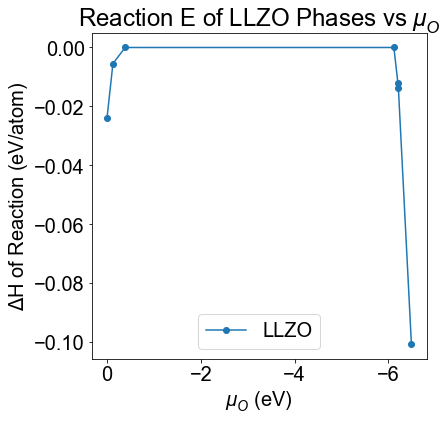

In [109]:
fig, ax = plt.subplots()

ax.set_ylabel(r'$\Delta$H of Reaction (eV/atom)')
ax.set_xlabel(r'$\mu_O$ (eV)')


p1 = plt.plot((LLZO[0]), LLZO[2], 'o-', label= r'LLZO')
#p2 = plt.plot((L_CO[0]), L_CO[2], 'o-', label= r'Li$_{0.5}$CoO$_2$')

legend = ax.legend(loc='lower center')

title  = plt.title(r'Reaction E of LLZO Phases vs $\mu_O$')
ax.invert_xaxis()
plt.show()

In [56]:
L_CO_500 = get_chempots_phases_enthalpies(['Li','Co','O'],'Li0.5CoO2','O', temp=500)
LCO_500 = get_chempots_phases_enthalpies(['Li','Co','O'],'LiCoO2','O', temp=500)
L_CO_800 = get_chempots_phases_enthalpies(['Li','Co','O'],'Li0.5CoO2','O', temp=800)
LCO_800 = get_chempots_phases_enthalpies(['Li','Co','O'],'LiCoO2','O', temp=800)

{'SO3': 0, 'SO2': 0, 'CO2': 0, 'O2': -0.2699917116035555}
H at -1.133:  -0.0640605351527
H at -6.2:  -2.11838230411
7
{'SO3': 0, 'SO2': 0, 'CO2': 0, 'O2': -0.2699917116035555}
H at -1.133:  1.17910288657e-15
H at -6.2:  -1.42059335638
6
{'SO3': 0, 'SO2': 0, 'CO2': 0, 'O2': -0.4050231119405361}
H at -1.133:  -0.0769206685181
H at -6.2:  -2.18589800427
7
{'SO3': 0, 'SO2': 0, 'CO2': 0, 'O2': -0.4050231119405361}
H at -1.133:  9.44873694609e-16
H at -6.2:  -1.47123013151
5


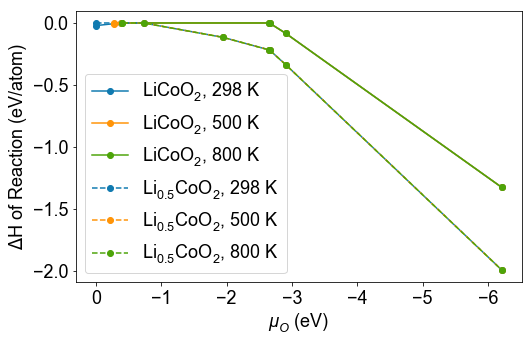

In [77]:
fig, ax = plt.subplots()

ax.set_ylabel(r'$\Delta$H of Reaction (eV/atom)')
ax.set_xlabel(r'$\mu_O$ (eV)')

p1 = plt.plot(LCO[0], LCO[2], 'o-', c=colo1, label= r'LiCoO$_2$, 298 K')
p2 = plt.plot(LCO_500[5], LCO_500[2], 'o-', c=colo2, label= r'LiCoO$_2$, 500 K')
p3 = plt.plot(LCO_800[5], LCO_800[2], 'o-', c=colo3, label= r'LiCoO$_2$, 800 K')

p4 = plt.plot(L_CO[0], L_CO[2], 'o--', c=colo1, label= r'Li$_{0.5}$CoO$_2$, 298 K')
p5 = plt.plot(L_CO_500[5], L_CO_500[2], 'o--', c=colo2, label= r'Li$_{0.5}$CoO$_2$, 500 K')
p6 = plt.plot(L_CO_800[5], L_CO_800[2], 'o--', c=colo3, label= r'Li$_{0.5}$CoO$_2$, 800 K')

legend = ax.legend(loc='lower left')

ax.invert_xaxis()
plt.show()

## LATP

In [46]:
LATP_LCO = get_chempots_phases_enthalpies(['Li','Al','Ti','P','Co','O'],'Li1.3Al0.3Ti1.7P3O12','O', binary='LiCoO2')
LATP_L_CO = get_chempots_phases_enthalpies(['Li','Al','Ti','P','Co','O'],'Li1.3Al0.3Ti1.7P3O12','O', binary='Li0.5CoO2')

H at -1.133:  -0.130122614053
H at -6.2:  -2.79231084917
32
H at -1.133:  -0.127675973018
H at -6.2:  -3.43083233338
35


In [211]:
s = 'Li0.1069477Ti0.04644809Al0.00819672Co0.14285714P0.08196721O0.61358314'
shortname = []
for r in LATP_L_CO[4]:
    new = r.replace(s, 'LATP-L(0.5)CO')
    shortname.append(new)
    
table = pnds.DataFrame({r'$\mu_O$* (eV)':LATP_L_CO[5],
                      'Phase Equilibria':LATP_L_CO[1],
                     r'$\Delta H_{rxn}$ at $\mu_O$ = 0.0':LATP_L_CO[3],
                    r'$\Delta H_{rxn}$ at $\mu_O$*':LATP_L_CO[2]})
reactions = pnds.DataFrame({'Reaction':shortname})
pnds.set_option('max_colwidth', 400)

display(table)
display(reactions)

,$\Delta H_{rxn}$ at $\mu_O$ = 0.0,$\Delta H_{rxn}$ at $\mu_O$*,$\mu_O$* (eV),Phase Equilibria
0,-0.004,-0.004,0.000,"[LiTi2(PO4)3, AlPO4, LiTiPO5, Li3PO4, CoO2]"
1,-0.000,-0.000,-0.051,"[LiTi2(PO4)3, Li(CoO2)2, Li3PO4, AlPO4]"
2,0.027,-0.000,-0.225,"[LiTi2(PO4)3, AlPO4, LiTiPO5, Li3PO4, Co3O4]"
3,0.030,-0.031,-0.489,"[AlPO4, Co3O4, LiTiPO5, Li3PO4, LiCoPO4]"
4,0.050,-0.052,-0.649,"[TiO2, AlPO4, LiCoPO4, Li3PO4, Co3O4]"
5,0.064,-0.141,-1.219,"[TiO2, Co3O4, Al(CoO2)2, Li3PO4, LiCoPO4]"
6,0.086,-0.183,-1.470,"[Ti2CoO5, Co3O4, Al(CoO2)2, Li3PO4, LiCoPO4]"
7,0.116,-0.268,-1.932,"[LiCoPO4, Co3O4, Al(CoO2)2, Li3PO4, TiCoO3]"
8,0.130,-0.270,-1.940,"[Li3PO4, LiCoPO4, Al(CoO2)2, CoO, TiCoO3]"
9,0.146,-0.278,-1.978,"[Al2CoO4, LiCoPO4, TiCoO3, Li3PO4, CoO]"


,Reaction
0,LATP-L(0.5)CO + 0.01786 O2 -> 0.005367 LiTi2(PO4)3 + 0.03571 LiTiPO5 + 0.02196 Li3PO4 + 0.1429 CoO2 + 0.008197 AlPO4
1,LATP-L(0.5)CO -> 0.02322 LiTi2(PO4)3 + 0.004098 Li3PO4 + 0.008197 AlPO4 + 0.07143 Li(CoO2)2
2,LATP-L(0.5)CO -> 0.02976 O2 + 0.005367 LiTi2(PO4)3 + 0.03571 LiTiPO5 + 0.02196 Li3PO4 + 0.04762 Co3O4 + 0.008197 AlPO4
3,LATP-L(0.5)CO -> 0.03155 O2 + 0.04645 LiTiPO5 + 0.01659 Li3PO4 + 0.04404 Co3O4 + 0.008197 AlPO4 + 0.01073 LiCoPO4
4,LATP-L(0.5)CO -> 0.03929 O2 + 0.01659 Li3PO4 + 0.02856 Co3O4 + 0.008197 AlPO4 + 0.05718 LiCoPO4 + 0.04645 TiO2
5,LATP-L(0.5)CO -> 0.04202 O2 + 0.008197 Al(CoO2)2 + 0.01249 Li3PO4 + 0.019 Co3O4 + 0.06948 LiCoPO4 + 0.04645 TiO2
6,LATP-L(0.5)CO -> 0.0459 O2 + 0.008197 Al(CoO2)2 + 0.02322 Ti2CoO5 + 0.01249 Li3PO4 + 0.01125 Co3O4 + 0.06948 LiCoPO4
7,LATP-L(0.5)CO -> 0.04977 O2 + 0.008197 Al(CoO2)2 + 0.04645 TiCoO3 + 0.01249 Li3PO4 + 0.003513 Co3O4 + 0.06948 LiCoPO4
8,LATP-L(0.5)CO -> 0.05152 O2 + 0.008197 Al(CoO2)2 + 0.04645 TiCoO3 + 0.01249 Li3PO4 + 0.01054 CoO + 0.06948 LiCoPO4
9,LATP-L(0.5)CO -> 0.05357 O2 + 0.004098 Al2CoO4 + 0.04645 TiCoO3 + 0.01249 Li3PO4 + 0.02283 CoO + 0.06948 LiCoPO4


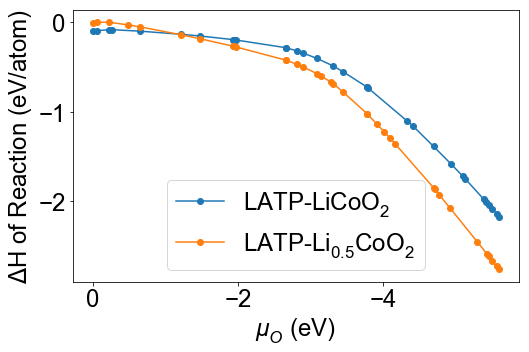

In [93]:
fig, ax = plt.subplots()

ax.set_ylabel(r'$\Delta$H of Reaction (eV/atom)')
ax.set_xlabel(r'$\mu_O$ (eV)')

p1 = plt.plot(LATP_LCO[0], LATP_LCO[2], 'o-', label= r'LATP-LiCoO$_2$')
p2 = plt.plot(LATP_L_CO[0], LATP_L_CO[2], 'o-', label= r'LATP-Li$_{0.5}$CoO$_2$')
legend = ax.legend(loc='lower center')

ax.invert_xaxis()
plt.show()

In [51]:
LATP_LCO_500 = get_chempots_phases_enthalpies(['Li','Al','Ti','P','Co','O'],'Li13Al3Ti17P30O120','O', temp=500, binary='LiCoO2')
LATP_L_CO_500 = get_chempots_phases_enthalpies(['Li','Al','Ti','P','Co','O'],'Li13Al3Ti17P30O120','O', temp=500, binary='Li0.5CoO2')
LATP_LCO_800 = get_chempots_phases_enthalpies(['Li','Al','Ti','P','Co','O'],'Li13Al3Ti17P30O120','O', temp=800, binary='LiCoO2')
LATP_L_CO_800 = get_chempots_phases_enthalpies(['Li','Al','Ti','P','Co','O'],'Li13Al3Ti17P30O120','O', temp=800, binary='Li0.5CoO2')

{'SO3': 0, 'SO2': 0, 'CO2': 0, 'O2': -0.2699917116035555}
H at -1.133:  -0.148855157351
H at -6.2:  -3.06882821164
29
{'SO3': 0, 'SO2': 0, 'CO2': 0, 'O2': -0.2699917116035555}
H at -1.133:  -0.17212203266
H at -6.2:  -3.72960177999
33
{'SO3': 0, 'SO2': 0, 'CO2': 0, 'O2': -0.4050231119405361}
H at -1.133:  -0.159741969887
H at -6.2:  -3.20712329652
29
{'SO3': 0, 'SO2': 0, 'CO2': 0, 'O2': -0.4050231119405361}
H at -1.133:  -0.195868978561
H at -6.2:  -3.87902582644
33


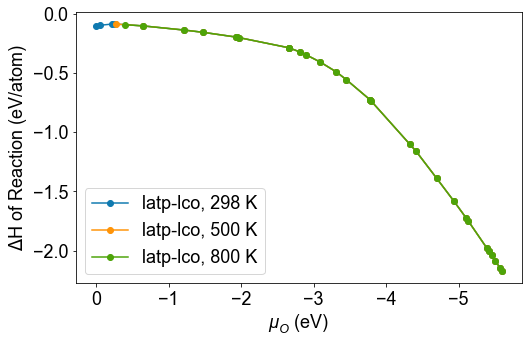

In [66]:
fig, ax = plt.subplots()

ax.set_ylabel(r'$\Delta$H of Reaction (eV/atom)')
ax.set_xlabel(r'$\mu_O$ (eV)')

p1 = plt.plot(LATP_LCO[0], LATP_LCO[2], 'o-', c='#107ab0', label= r'latp-lco, 298 K')
p2 = plt.plot(LATP_LCO_500[5], LATP_LCO_500[2], 'o-', c='#ff9408', label= r'latp-lco, 500 K')
p3 = plt.plot(LATP_LCO_800[5], LATP_LCO_800[2], 'o-', c='#4da409', label= r'latp-lco, 800 K')

# p4 = plt.plot(LATP_L_CO[0], LATP_L_CO[2], 'o--', c='#107ab0', label= r'latp-l$_{0.5}$co, 300 K')
# p5 = plt.plot(LATP_L_CO_500[5], LATP_L_CO_500[2], 'o--', c='#ff9408', label= r'latp-l$_{0.5}$co, 500 K')
# p6 = plt.plot(LATP_L_CO_800[5], LATP_L_CO_800[2], 'o--', c='#4da409', label= r'latp-l$_{0.5}$co, 800 K')
ax.legend(loc='lower left')
ax.invert_xaxis()
plt.show()

## LPS

In [47]:
LPS = get_chempots_phases_enthalpies(['Li','P','S','O'],'Li3PS4','O')

H at -1.133:  -3.02878598755
H at -6.2:  2.22396389694
8


In [70]:
LPS_500 = get_chempots_phases_enthalpies(['Li','P','S','O'],'Li3PS4','O', temp=500)
LPS_L_CO = get_chempots_phases_enthalpies(['Li','P','S','Co','O'],'Li3PS4','O', binary='Li0.5CoO2')

{'SO3': -0.14972980937470637, 'SO2': -0.19946079980922138, 'CO2': 0, 'O2': -0.2699917116035555}
H at -1.133:  -2.61199062408
H at -6.2:  2.41295809506
6
H at -1.133:  -3.55303807335
H at -6.2:  -1.70393403891
18


In [216]:
s = 'Li0.25892857Co0.14285714P0.0625S0.25O0.28571429'
shortname = []
for r in LPS_L_CO[4]:
    new = r.replace(s, 'LPS-L(0.5)CO')
    shortname.append(new)
    
table = pnds.DataFrame({r'$\mu_O$* (eV)':LPS_L_CO[5],
                      'Phase Equilibria':LPS_L_CO[1],
                     r'$\Delta H_{rxn}$ at $\mu_O$ = 0.0':LPS_L_CO[3],
                    r'$\Delta H_{rxn}$ at $\mu_O$*':LPS_L_CO[2],
                        'Reaction':shortname})
pnds.set_option('max_colwidth', 400)

display(table)

,$\Delta H_{rxn}$ at $\mu_O$ = 0.0,$\Delta H_{rxn}$ at $\mu_O$*,$\mu_O$* (eV),Phase Equilibria,Reaction
0,-5.594,-5.594,0.000,"[Li2SO4, CoPO4, CoSO4, Li2S2O7]",0.4621 O2 + LPS-L(0.5)CO -> 0.04018 Li2S2O7 + 0.08036 CoSO4 + 0.0625 CoPO4 + 0.08929 Li2SO4
1,-5.586,-5.214,-0.205,"[Li2SO4, CoPO4, CoSO4, Co(PO3)3]",0.452 O2 + LPS-L(0.5)CO -> 0.1205 CoSO4 + 0.002232 CoPO4 + 0.1295 Li2SO4 + 0.02009 Co(PO3)3
2,-5.585,-5.167,-0.231,"[Li2SO4, Co(PO3)3, LiCo(PO3)4, CoSO4]",0.4509 O2 + LPS-L(0.5)CO -> 0.125 CoSO4 + 0.008929 Co(PO3)3 + 0.125 Li2SO4 + 0.008929 LiCo(PO3)4
3,-5.584,-5.144,-0.244,"[Li2SO4, Li2S2O7, LiCo(PO3)4, CoSO4]",0.4503 O2 + LPS-L(0.5)CO -> 0.001116 Li2S2O7 + 0.1272 CoSO4 + 0.1205 Li2SO4 + 0.01563 LiCo(PO3)4
4,-5.576,-4.651,-0.518,"[Li2SO4, Co(PO3)2, CoSO4, Li2S2O7]",0.4464 O2 + LPS-L(0.5)CO -> 0.008929 Li2S2O7 + 0.1116 CoSO4 + 0.03125 Co(PO3)2 + 0.1205 Li2SO4
5,-5.534,-1.396,-2.341,"[Li2SO4, SO2, CoSO4, Co(PO3)2]",0.442 O2 + LPS-L(0.5)CO -> 0.008929 SO2 + 0.1116 CoSO4 + 0.03125 Co(PO3)2 + 0.1295 Li2SO4
6,-5.281,-1.351,-2.366,"[Li2SO4, Co(PO3)2, CoSO4, CoS2]",0.4152 O2 + LPS-L(0.5)CO -> 0.1027 CoSO4 + 0.03125 Co(PO3)2 + 0.1295 Li2SO4 + 0.008929 CoS2
7,-3.553,-1.289,-2.403,"[Li2SO4, CoS2, Co(PO3)2, Co3(PO4)2]",0.2355 O2 + LPS-L(0.5)CO -> 0.06027 CoS2 + 0.00558 Co(PO3)2 + 0.1295 Li2SO4 + 0.02567 Co3(PO4)2
8,-3.173,-1.260,-2.435,"[LiCoPO4, CoS2, Co3(PO4)2, Li2SO4]",0.1964 O2 + LPS-L(0.5)CO -> 0.1071 Li2SO4 + 0.008929 Co3(PO4)2 + 0.07143 CoS2 + 0.04464 LiCoPO4
9,-2.999,-1.258,-2.437,"[Co3S4, LiCoPO4, CoS2, Li2SO4]",0.1786 O2 + LPS-L(0.5)CO -> 0.09821 Li2SO4 + 0.06696 CoS2 + 0.004464 Co3S4 + 0.0625 LiCoPO4


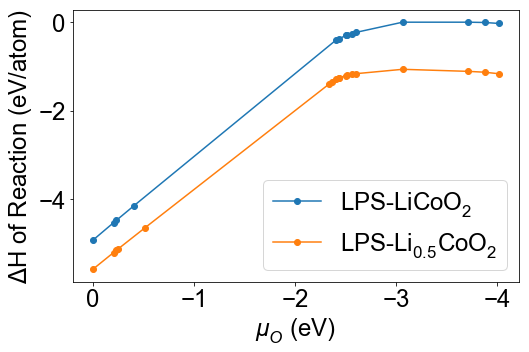

In [95]:
fig, ax = plt.subplots()

ax.set_ylabel(r'$\Delta$H of Reaction (eV/atom)')
ax.set_xlabel(r'$\mu_O$ (eV)')

p1 = plt.plot(LPS_LCO[0], LPS_LCO[2], 'o-', label= r'LPS-LiCoO$_2$')
p2 = plt.plot(LPS_L_CO[0], LPS_L_CO[2], 'o-', label= r'LPS-Li$_{0.5}$CoO$_2$')
legend = ax.legend(loc='lower right')

ax.invert_xaxis()
plt.show()

In [52]:
LPS_LCO_500 = get_chempots_phases_enthalpies(['Li','P','S','Co','O'],'Li3PS4','O', temp=500, binary='LiCoO2')
LPS_L_CO_500 = get_chempots_phases_enthalpies(['Li','P','S','Co','O'],'Li3PS4','O', temp=500, binary='Li0.5CoO2')
LPS_LCO_800 = get_chempots_phases_enthalpies(['Li','P','S','Co','O'],'Li3PS4','O', temp=800, binary='LiCoO2')
LPS_L_CO_800 = get_chempots_phases_enthalpies(['Li','P','S','Co','O'],'Li3PS4','O', temp=800, binary='Li0.5CoO2')

{'SO3': -0.14972980937470637, 'SO2': -0.19946079980922138, 'CO2': 0, 'O2': -0.2699917116035555}
H at -1.133:  -2.28748949559
H at -6.2:  -0.402885158899
13
{'SO3': -0.14972980937470637, 'SO2': -0.19946079980922138, 'CO2': 0, 'O2': -0.2699917116035555}
H at -1.133:  -3.07143009958
H at -6.2:  -1.77036057113
14
{'SO3': -0.2389397321974141, 'SO2': -0.3185049777184428, 'CO2': 0, 'O2': -0.4050231119405361}
H at -1.133:  -2.0469110572
H at -6.2:  -0.423514956173
13
{'SO3': -0.2389397321974141, 'SO2': -0.3185049777184428, 'CO2': 0, 'O2': -0.4050231119405361}
H at -1.133:  -2.84928017356
H at -6.2:  -1.80358258233
13


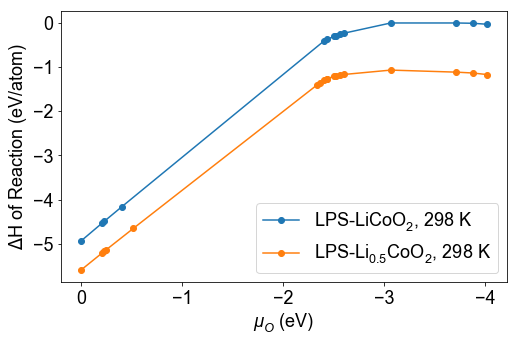

In [90]:
fig, ax = plt.subplots()

ax.set_ylabel(r'$\Delta$H of Reaction (eV/atom)')
ax.set_xlabel(r'$\mu_O$ (eV)')

p1 = plt.plot(LPS_LCO[0], LPS_LCO[2], 'o-', label= r'LPS-LiCoO$_2$, 298 K')
# p2 = plt.plot(LPS_LCO_500[5], LPS_LCO_500[2], 'o-', c=colo2, label= r'LPS-LiCoO$_2$, 500 K')
# p3 = plt.plot(LPS_LCO_800[5], LPS_LCO_800[2], 'o-', c=colo3, label= r'LPS-LiCoO$_2$, 800 K')

p4 = plt.plot(LPS_L_CO[0], LPS_L_CO[2], 'o-', label= r'LPS-Li$_{0.5}$CoO$_2$, 298 K')
# p5 = plt.plot(LPS_L_CO_500[5], LPS_L_CO_500[2], 'o--', c='#ff9408', label= r'LPS-Li$_{0.5}$CoO$_2$, 500 K')
# p6 = plt.plot(LPS_L_CO_800[5], LPS_L_CO_800[2], 'o--', c='#4da409', label= r'LPS-Li$_{0.5}$CoO$_2$, 800 K')

legend = ax.legend(loc='lower right')

ax.invert_xaxis()
plt.show()

## LLZO

In [49]:
LLZO_LCO = get_chempots_phases_enthalpies(['Li','La','Zr','Co','O'],'Li7La3Zr2O12','O', binary='LiCoO2')
LLZO_L_CO = get_chempots_phases_enthalpies(['Li','La','Zr','Co','O'],'Li7La3Zr2O12','O', binary='Li0.5CoO2')

H at -1.133:  -0.000365850690103
H at -6.2:  -1.39132052211
13
H at -1.133:  -0.107659349707
H at -6.2:  -2.05959405632
12


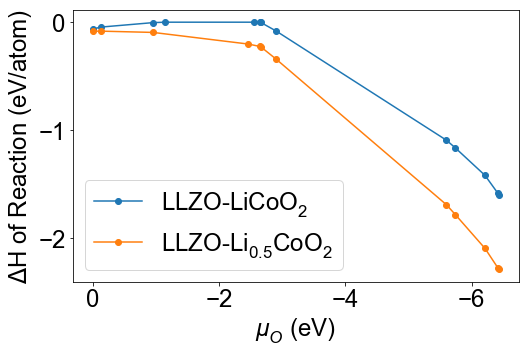

In [97]:
fig, ax = plt.subplots()

ax.set_ylabel(r'$\Delta$H of Reaction (eV/atom)')
ax.set_xlabel(r'$\mu_O$ (eV)')

p1 = plt.plot(LLZO_LCO[0], LLZO_LCO[2], 'o-', label= r'LLZO-LiCoO$_2$')
p2 = plt.plot(LLZO_L_CO[5], LLZO_L_CO[2], 'o-', label= r'LLZO-Li$_{0.5}$CoO$_2$')

legend = ax.legend(loc='lower left')

ax.invert_xaxis()
plt.show()

In [53]:
LLZO_LCO_500 = get_chempots_phases_enthalpies(['Li','La','Zr','Co','O'],'Li7La3Zr2O12','O', temp=500, binary='LiCoO2')
LLZO_L_CO_500 = get_chempots_phases_enthalpies(['Li','La','Zr','Co','O'],'Li7La3Zr2O12','O', temp=500, binary='Li0.5CoO2')
LLZO_LCO_800 = get_chempots_phases_enthalpies(['Li','La','Zr','Co','O'],'Li7La3Zr2O12','O', temp=800, binary='LiCoO2')
LLZO_L_CO_800 = get_chempots_phases_enthalpies(['Li','La','Zr','Co','O'],'Li7La3Zr2O12','O', temp=800, binary='Li0.5CoO2')

{'SO3': 0, 'SO2': 0, 'CO2': 0, 'O2': -0.2699917116035555}
H at -1.133:  -6.64456739407e-14
H at -6.2:  -1.63318809709
12
{'SO3': 0, 'SO2': 0, 'CO2': 0, 'O2': -0.2699917116035555}
H at -1.133:  -0.126944471965
H at -6.2:  -2.33038931468
11
{'SO3': 0, 'SO2': 0, 'CO2': 0, 'O2': -0.4050231119405361}
H at -1.133:  -5.77328551757e-14
H at -6.2:  -1.75415372656
12
{'SO3': 0, 'SO2': 0, 'CO2': 0, 'O2': -0.4050231119405361}
H at -1.133:  -0.136589571989
H at -6.2:  -2.46582259418
11


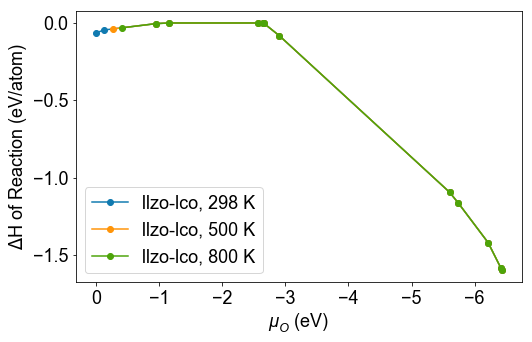

In [67]:
fig, ax = plt.subplots()

ax.set_ylabel(r'$\Delta$H of Reaction (eV/atom)')
ax.set_xlabel(r'$\mu_O$ (eV)')

p1 = plt.plot(LLZO_LCO[0], LLZO_LCO[2], 'o-', c='#107ab0', label= r'llzo-lco, 298 K')
p2 = plt.plot(LLZO_LCO_500[5], LLZO_LCO_500[2], 'o-', c='#ff9408', label= r'llzo-lco, 500 K')
p3 = plt.plot(LLZO_LCO_800[5], LLZO_LCO_800[2], 'o-', c='#4da409', label= r'llzo-lco, 800 K')

# p4 = plt.plot(LLZO_L_CO[0], LLZO_L_CO[2], 'o--', c='#107ab0', label= r'llzo-l$_{0.5}$co, 300 K')
# p5 = plt.plot(LLZO_L_CO_500[5], LLZO_L_CO_500[2], 'o--', c='#ff9408', label= r'llzo-l$_{0.5}$co, 500 K')
# p6 = plt.plot(LLZO_L_CO_800[5], LLZO_L_CO_800[2], 'o--', c='#4da409', label= r'llzo-l$_{0.5}$co, 800 K')

legend = ax.legend(loc='lower left')

ax.invert_xaxis()
plt.show()

In [50]:
LATP = get_chempots_phases_enthalpies(['Li','Al','Ti','P','O'],'Li13Al3Ti17P30O120','O')
LLZO = get_chempots_phases_enthalpies(['Li','La','Zr','O'],'Li7La3Zr2O12','O')

H at -1.133:  -1.84671389012e-15
H at -6.2:  -1.33291973003
12
H at -1.133:  1.87932282922e-16
H at -6.2:  -0.00958317190104
7


In [54]:
LATP_500 = get_chempots_phases_enthalpies(['Li','Al','Ti','P','O'],'Li13Al3Ti17P30O120','O', temp=500)
LLZO_500 = get_chempots_phases_enthalpies(['Li','La','Zr','O'],'Li7La3Zr2O12','O', temp=500)
LATP_800 = get_chempots_phases_enthalpies(['Li','Al','Ti','P','O'],'Li13Al3Ti17P30O120','O', temp=800)
LLZO_800 = get_chempots_phases_enthalpies(['Li','La','Zr','O'],'Li7La3Zr2O12','O', temp=800)

{'SO3': 0, 'SO2': 0, 'CO2': 0, 'O2': -0.2699917116035555}
H at -1.133:  -6.67540318499e-16
H at -6.2:  -1.50553738171
12
{'SO3': 0, 'SO2': 0, 'CO2': 0, 'O2': -0.2699917116035555}
H at -1.133:  6.13013791861e-16
H at -6.2:  -0.0939555817772
6
{'SO3': 0, 'SO2': 0, 'CO2': 0, 'O2': -0.4050231119405361}
H at -1.133:  -6.81585970796e-16
H at -6.2:  -1.59186893274
12
{'SO3': 0, 'SO2': 0, 'CO2': 0, 'O2': -0.4050231119405361}
H at -1.133:  3.25874352105e-16
H at -6.2:  -0.136152894382
5


In [74]:
name = []
s = 'Li0.2172619La0.0625Zr0.04166667Co0.14285714O0.53571429'
for r in LLZO_L_CO[4]:
    new = r.replace(s, 'LLZO-0.5LCO')
    name.append(new)
    
pnds.options.display.float_format = '{:.3f}'.format
table = pnds.DataFrame({r'$\mu_O$ (eV)':LLZO_L_CO[5],
                      'Phase Equilibria':LLZO_L_CO[1],
                    r'$\Delta H_{rxn}$ at $\mu_O$':LLZO_L_CO[2],
                        'Reaction':name})
pnds.set_option('max_colwidth', 400)
display(table)

,$\Delta H_{rxn}$ at $\mu_O$,$\mu_O$ (eV),Phase Equilibria,Reaction
0,-0.083,0.000,"[Li7Co5O12, La2O3, La2Zr2O7, Li2O2]",0.000744 O2 + LLZO-0.5LCO -> 0.01042 La2O3 + 0.008631 Li2O2 + 0.02857 Li7Co5O12 + 0.02083 La2Zr2O7
1,-0.083,-0.126,"[Li7Co5O12, La2O3, La2Zr2O7, Li6Zr2O7]",LLZO-0.5LCO -> 0.003571 O2 + 0.01329 La2O3 + 0.002877 Li6Zr2O7 + 0.02857 Li7Co5O12 + 0.01796 La2Zr2O7
2,-0.095,-0.953,"[La2O3, La2Zr2O7, Li6Zr2O7, LiCoO2]",LLZO-0.5LCO -> 0.01786 O2 + 0.02282 La2O3 + 0.0124 Li6Zr2O7 + 0.1429 LiCoO2 + 0.008433 La2Zr2O7
3,-0.203,-2.463,"[La2O3, CoO, LiCoO2, Li6Zr2O7]",LLZO-0.5LCO -> 0.03051 O2 + 0.03125 La2O3 + 0.0506 CoO + 0.09226 LiCoO2 + 0.02083 Li6Zr2O7
4,-0.225,-2.644,"[Li6CoO4, CoO, Li6Zr2O7, La2O3]",LLZO-0.5LCO -> 0.05357 O2 + 0.02083 Li6Zr2O7 + 0.1275 CoO + 0.01538 Li6CoO4 + 0.03125 La2O3
5,-0.228,-2.660,"[Li6CoO4, Li6Zr2O7, Co, La2O3]",LLZO-0.5LCO -> 0.1173 O2 + 0.1275 Co + 0.03125 La2O3 + 0.02083 Li6Zr2O7 + 0.01538 Li6CoO4
6,-0.342,-2.903,"[La2O3, Li6Zr2O7, Co, Li2O]",LLZO-0.5LCO -> 0.125 O2 + 0.1429 Co + 0.03125 La2O3 + 0.02083 Li6Zr2O7 + 0.04613 Li2O
7,-1.692,-5.602,"[Zr6Co23, La2O3, Li6Zr2O7, Li2O]",LLZO-0.5LCO -> 0.1623 O2 + 0.102 Li2O + 0.03125 La2O3 + 0.006211 Zr6Co23 + 0.0022 Li6Zr2O7
8,-1.782,-5.742,"[Zr6Co23, La2O3, Li2O, ZrCo2]",LLZO-0.5LCO -> 0.1667 O2 + 0.1086 Li2O + 0.03125 La2O3 + 0.009199 ZrCo2 + 0.005411 Zr6Co23
9,-2.096,-6.213,"[Zr6Co23, La2O3, Li, ZrCo2]",LLZO-0.5LCO -> 0.221 O2 + 0.2173 Li + 0.03125 La2O3 + 0.009199 ZrCo2 + 0.005411 Zr6Co23


In [42]:
table.to_csv('out.txt', sep='\t')

In [143]:
table = pnds.DataFrame({r'$\mu_O$ (eV)':LPS[5],
                      'Phase Equilibria':LPS[1],
                    r'$\Delta H_{rxn}$ at $\mu_O$':LPS[2],
                        'Reaction':LPS[4]})
pnds.set_option('max_colwidth', 400)

display(table)

,$\Delta H_{rxn}$ at $\mu_O$,$\mu_O$ (eV),Phase Equilibria,Reaction
0,-5.295,0.000,"[Li2S2O7, SO3, P2O5]",8 O2 + Li3PS4 -> SO3 + 1.5 Li2S2O7 + 0.5 P2O5
1,-1.753,-1.771,"[Li2S2O7, SO2, P2O5]",7.5 O2 + Li3PS4 -> SO2 + 1.5 Li2S2O7 + 0.5 P2O5
2,-1.300,-2.012,"[Li2S2O7, SO2, LiPO3]",7 O2 + Li3PS4 -> 2 SO2 + LiPO3 + Li2S2O7
3,-0.726,-2.341,"[Li2SO4, SO2, LiPO3]",6.5 O2 + Li3PS4 -> 3 SO2 + LiPO3 + Li2SO4
4,-0.313,-2.594,"[Li2SO4, P2S7, LiPO3]",3.125 O2 + Li3PS4 -> 0.25 LiPO3 + 1.375 Li2SO4 + 0.375 P2S7
5,-0.214,-2.722,"[Li4P2O7, P2S7, Li2SO4]",2.944 O2 + Li3PS4 -> 0.1111 Li4P2O7 + 1.278 Li2SO4 + 0.3889 P2S7
6,-0.151,-2.807,"[Li3PO4, P2S7, Li2SO4]",2.8 O2 + Li3PS4 -> 0.2 Li3PO4 + 1.2 Li2SO4 + 0.4 P2S7
7,0.000,-3.023,[Li3PS4],Li3PS4 -> Li3PS4


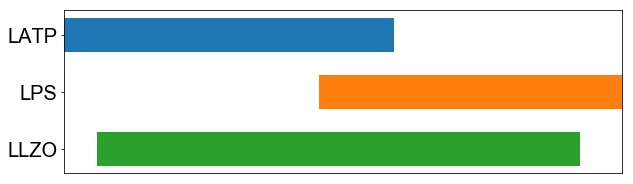

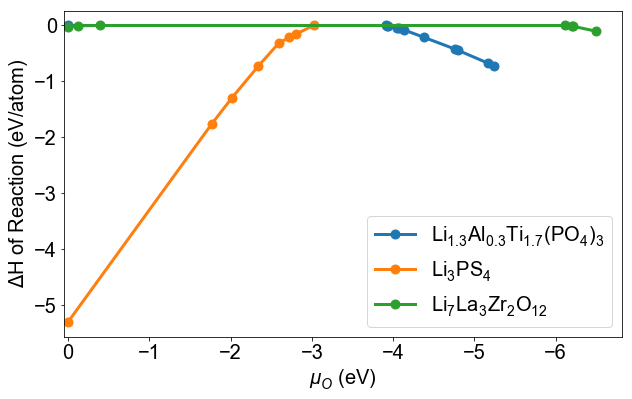

In [184]:
length = [LLZO[0][2]-LLZO[0][3], LPS[0][7]-LLZO[0][3]+0.5, LATP[0][0]-LATP[0][1]]
bottom = [LLZO[0][3], LLZO[0][3]-0.5, LATP[0][1]]
length = tuple(length)
bottom = tuple(bottom)
ind = np.arange(3)  # the y locations for the groups
width = 0.6       # the width of the bars

mpl.rcParams["figure.figsize"] = (10,3)
plt.figure(1)
fig, ax = plt.subplots()
rects = ax.barh(ind + width/2., length, width, bottom, align= 'center', color=['#2ca02c','#ff7f0e', '#1f77b4'])
plt.yticks(ind +0.3, ('LLZO', 'LPS', 'LATP'))
xi, xf = ax.get_xlim()
ax.set_xlim([xi, 0])
plt.xticks([])
ax.invert_xaxis()
#['#82cafc','#fcb001', '#96f97b'] ['#2ca02c','#ff7f0e', '#1f77b4']

mpl.rcParams["figure.figsize"] = (10,6)
plt.figure(2)
fig, ax = plt.subplots()
ax.set_ylabel(r'$\Delta$H of Reaction (eV/atom)')
ax.set_xlabel(r'$\mu_O$ (eV)')

p1 = plt.plot(LATP[0], LATP[2], 'o-', ms=9, lw=3, label= r'Li$_{1.3}$Al$_{0.3}$Ti$_{1.7}$(PO$_4$)$_3$')
p2 = plt.plot(LPS[0], LPS[2], 'o-', ms=9, lw=3, label= r'Li$_3$PS$_4$')
p3 = plt.plot(LLZO[0], LLZO[2], 'o-', ms=9, lw=3, label= r'Li$_7$La$_3$Zr$_2$O$_{12}$')
ax.legend(loc='lower right')
xi, xf = ax.get_xlim()
ax.set_xlim([xi, 0.05])
ax.invert_xaxis()



# plt.figure(2)

# fig, ax = plt.subplots()

# #ax.set_ylabel(r'$\Delta$H of Reaction (eV/atom)')
# ax.set_xlabel(r'$\mu_O$ (eV)')
# p3 = plt.plot(LATP[0], LATP[2], 'o-', label= r'llzo, 298 K')
# p4 = plt.plot(LATP_500[5], LATP_500[2], 'o-', label= r'latp, 500 K')
# p5 = plt.plot(LATP_800[5], LATP_800[2], 'o-', label= r'latp, 800 K')
# ax.invert_xaxis()
# ax.legend(loc='lower left')

# plt.figure(3)

# fig, ax = plt.subplots()

# #ax.set_ylabel(r'$\Delta$H of Reaction (eV/atom)')
# ax.set_xlabel(r'$\mu_O$ (eV)')
# p3 = plt.plot(LLZO[0], LLZO[2], 'o-', label= r'llzo')
# # p4 = plt.plot(LLZO_500[5], LLZO_500[2], 'o-', label= r'llzo, 500 K')
# # p5 = plt.plot(LLZO_800[5], LLZO_800[2], 'o-', label= r'llzo, 800 K')
# ax.invert_xaxis()
# ax.legend(loc='lower left')

In [58]:
li = get_chempots_phases_enthalpies(['Li','O'],'Li','O')
si = get_chempots_phases_enthalpies(['Si', 'O'], 'Si', 'O')
c = get_chempots_phases_enthalpies(['C', 'O'], 'C', 'O')

H at -1.133:  -2.53988955563
H at -6.2:  -0.006389555625
3
H at -1.133:  -7.5879400725
H at -6.2:  2.5460599275
2
H at -1.133:  -3.09961966375
H at -6.2:  7.03438033625
2


In [66]:
table = pnds.DataFrame({r'$\mu_O$ (eV)':li[5],
                      'Phase Equilibria':li[1],
                     r'$\Delta H_{rxn}$ at $\mu_O$':li[2],
                        'Reaction':li[4]})
table2 = pnds.DataFrame({r'$\mu_O$ (eV)':li_500[5],
                      'Phase Equilibria':li_500[1],
                     r'$\Delta H_{rxn}$ at $\mu_O$':li_500[2],
                        'Reaction':li_500[4]})
table3 = pnds.DataFrame({r'$\mu_O$ (eV)':li_500[5],
                      'Phase Equilibria':li_500[1],
                     r'$\Delta H_{rxn}$ at $\mu_O$':li_500[2],
                        'Reaction':li_500[4]})
display(table)
display(table2)
display(table3)

,$\Delta H_{rxn}$ at $\mu_O$,$\mu_O$ (eV),Phase Equilibria,Reaction
0,-3.300,0.000,[Li2O2],0.5 O2 + Li -> 0.5 Li2O2
1,-2.913,-0.387,[Li2O],0.25 O2 + Li -> 0.5 Li2O
2,0.000,-6.213,[Li],Li -> Li


,$\Delta H_{rxn}$ at $\mu_O$,$\mu_O$ (eV),Phase Equilibria,Reaction
0,-3.030,-0.270,[Li2O2],0.5 O2 + Li -> 0.5 Li2O2
1,-2.913,-0.387,[Li2O],0.25 O2 + Li -> 0.5 Li2O
2,0.000,-6.213,[Li],Li -> Li


,$\Delta H_{rxn}$ at $\mu_O$,$\mu_O$ (eV),Phase Equilibria,Reaction
0,-3.030,-0.270,[Li2O2],0.5 O2 + Li -> 0.5 Li2O2
1,-2.913,-0.387,[Li2O],0.25 O2 + Li -> 0.5 Li2O
2,0.000,-6.213,[Li],Li -> Li


In [63]:
li_500 = get_chempots_phases_enthalpies(['Li','O'],'Li','O', temp=500)
li_800 = get_chempots_phases_enthalpies(['Li','O'],'Li','O', temp=800)

{'SO3': 0, 'SO2': 0, 'CO2': 0, 'O2': -0.2699917116035555}
H at -1.133:  -2.40489369982
H at -6.2:  0.128606300177
3
{'SO3': 0, 'SO2': 0, 'CO2': 0, 'O2': -0.4050231119405361}
H at -1.133:  -2.33737799965
H at -6.2:  0.196122000345
2


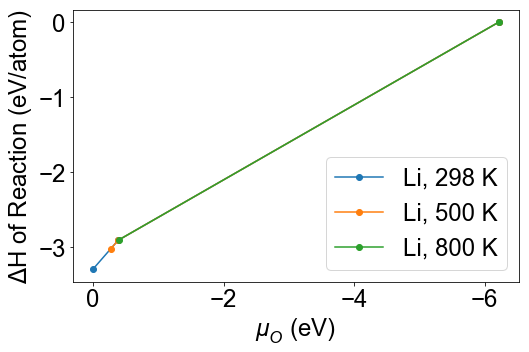

In [71]:
fig, ax = plt.subplots()
ax.set_ylabel(r'$\Delta$H of Reaction (eV/atom)')
ax.set_xlabel(r'$\mu_O$ (eV)')

p1 = plt.plot(li[5], li[2], 'o-', label= r'Li, 298 K')
p2 = plt.plot(li_500[5], li_500[2], 'o-', label= r'Li, 500 K')
p3 = plt.plot(li_800[5], li_800[2], 'o-', label= r'Li, 800 K')
ax.legend(loc='lower right')
ax.invert_xaxis()